In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from copy import deepcopy

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Cuda or CPU availability: {device}")

Cuda or CPU availability: cuda


In [9]:
data = pd.read_csv('../data/tsla_daily.csv')
data

,Date,Open,High,Low,Close,Volume
0,2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500
1,2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500
2,2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000
3,2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500
4,2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500
...,...,...,...,...,...,...
964,2023-10-31 00:00:00-04:00,196.119995,202.800003,194.070007,200.839996,118068300
965,2023-11-01 00:00:00-04:00,204.039993,205.990005,197.850006,205.660004,121661700
966,2023-11-02 00:00:00-04:00,212.970001,219.199997,211.449997,218.509995,125987600
967,2023-11-03 00:00:00-04:00,221.149994,226.369995,218.399994,219.960007,119281000


           Date       Close
0    2020-01-02   28.684000
1    2020-01-03   29.534000
2    2020-01-06   30.102667
3    2020-01-07   31.270666
4    2020-01-08   32.809334
..          ...         ...
964  2023-10-31  200.839996
965  2023-11-01  205.660004
966  2023-11-02  218.509995
967  2023-11-03  219.960007
968  2023-11-06  219.270004

[969 rows x 2 columns]


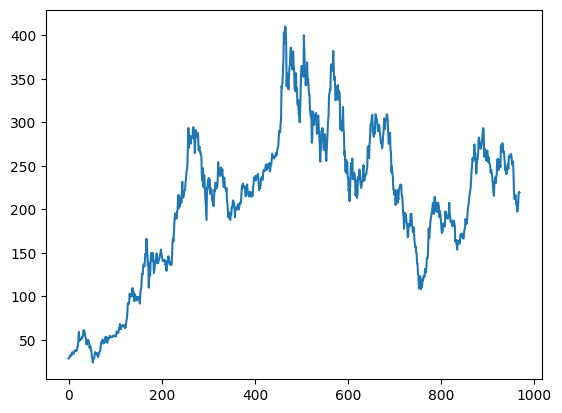

In [29]:
TSLA = data[['Date', 'Close']].copy()   
TSLA['Date'] = pd.to_datetime(TSLA['Date'], utc=True).dt.strftime('%Y-%m-%d')

print(TSLA)

plt.plot(TSLA.Close)

In [41]:
def lstm_preprocessing(df, n_steps):
    df = deepcopy(df)
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps):
        df[f"Close(t-{n_steps - i})"] = df['Close'].shift(n_steps - i)

    df.dropna(inplace=True)

    return df

steps = 8
TSLA_shifted = lstm_preprocessing(TSLA, steps)
TSLA_shifted

,Close,Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
Date,,,,,,,,
2020-01-13,34.990665,28.684000,29.534000,30.102667,31.270666,32.809334,32.089333,31.876667
2020-01-14,35.861332,29.534000,30.102667,31.270666,32.809334,32.089333,31.876667,34.990665
2020-01-15,34.566666,30.102667,31.270666,32.809334,32.089333,31.876667,34.990665,35.861332
2020-01-16,34.232666,31.270666,32.809334,32.089333,31.876667,34.990665,35.861332,34.566666
2020-01-17,34.033333,32.809334,32.089333,31.876667,34.990665,35.861332,34.566666,34.232666
...,...,...,...,...,...,...,...,...
2023-10-31,200.839996,211.990005,212.080002,216.520004,212.419998,205.759995,207.300003,197.360001
2023-11-01,205.660004,212.080002,216.520004,212.419998,205.759995,207.300003,197.360001,200.839996
2023-11-02,218.509995,216.520004,212.419998,205.759995,207.300003,197.360001,200.839996,205.660004


In [42]:
TSLA_shifted_np = TSLA_shifted.to_numpy()

TSLA_shifted_np



array([[ 34.99066544,  28.68400002,  29.5340004 , ...,  32.8093338 ,
         32.08933258,  31.87666702],
       [ 35.86133194,  29.5340004 ,  30.10266685, ...,  32.08933258,
         31.87666702,  34.99066544],
       [ 34.56666565,  30.10266685,  31.27066612, ...,  31.87666702,
         34.99066544,  35.86133194],
       ...,
       [218.50999451, 216.52000427, 212.41999817, ..., 197.36000061,
        200.83999634, 205.66000366],
       [219.96000671, 212.41999817, 205.75999451, ..., 200.83999634,
        205.66000366, 218.50999451],
       [219.27000427, 205.75999451, 207.30000305, ..., 205.66000366,
        218.50999451, 219.96000671]])

In [43]:
scaler = MinMaxScaler(feature_range=(-1,1))
TSLA_shifted_scaled_np = scaler.fit_transform(TSLA_shifted_np)

TSLA_shifted_scaled_np

array([[-0.94345865, -0.9761451 , -0.97173969, ..., -0.95476415,
        -0.9584958 , -0.95959802],
       [-0.93894613, -0.97173969, -0.96879238, ..., -0.9584958 ,
        -0.95959802, -0.94345865],
       [-0.94565618, -0.96879238, -0.96273882, ..., -0.95959802,
        -0.94345865, -0.93894613],
       ...,
       [ 0.00769303, -0.00262077, -0.02387045, ..., -0.10192404,
        -0.08388777, -0.05890644],
       [ 0.01520822, -0.02387045, -0.0583882 , ..., -0.08388777,
        -0.05890644,  0.00769303],
       [ 0.01163204, -0.0583882 , -0.05040658, ..., -0.05890644,
         0.00769303,  0.01520822]])

In [54]:
X = TSLA_shifted_scaled_np[:, 1:]
y = TSLA_shifted_scaled_np[:, 0]

print(f"Shape of features: {X.shape}")
print(f"Shape of label: {y.shape}")

Shape of features: (962, 7)
Shape of label: (962,)


In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state=123
)

print(f"Training X, y shape: {X_train.shape}, {y_train.shape}")
print(f"Test X, y shape: {X_test.shape}, {y_test.shape}")

Training X, y shape: (769, 7), (769,)
Test X, y shape: (193, 7), (193,)


In [56]:
X_train = X_train.reshape((-1,7,1))
X_test = X_test.reshape((-1,7,1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

print('----- After reshaping -----')
print(f"Training X, y shape: {X_train.shape}, {y_train.shape}")
print(f"Test X, y shape: {X_test.shape}, {y_test.shape}")


----- After reshaping -----
Training X, y shape: (769, 7, 1), (769, 1)
Test X, y shape: (193, 7, 1), (193, 1)


In [57]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

print('----- Convert to Torch Tensor -----')
print(f"Training X, y shape: {X_train.shape}, {y_train.shape}")
print(f"Test X, y shape: {X_test.shape}, {y_test.shape}")

----- Convert to Torch Tensor -----
Training X, y shape: torch.Size([769, 7, 1]), torch.Size([769, 1])
Test X, y shape: torch.Size([193, 7, 1]), torch.Size([193, 1])


In [59]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [61]:
torch.manual_seed(123)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [65]:
train_loader.dataset

In [72]:
for i, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break
    # print(batch)
    


torch.Size([16, 7, 1]) torch.Size([16, 1])


In [76]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_stacked_layers,
            batch_first = True
        )
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ =  self.lstm(x, (h0, c0))
        out = self.linear(out[:, -1, :])
        return out


model = LSTM(1, 4, 1)
model.to(device)
model


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

In [77]:
learning_rate = 0.01
num_epochs = 10
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


In [ ]:
for epoch in range(num_epochs):
    model.train(True)
    print(f"Epoch: {epoch + 1}")
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)

